# VRNN
Original paper: A Recurrent Latent Variable Model for Sequential Data (https://arxiv.org/pdf/1506.02216.pdf )

In [2]:
from tqdm import tqdm
import numpy as np
import random

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from tensorboardX import SummaryWriter

batch_size = 4
epochs = 10
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [5]:
from pixyz.models import Model
from pixyz.losses import KullbackLeibler, StochasticReconstructionLoss
from pixyz.losses import IterativeLoss
from pixyz.distributions import Bernoulli, Normal, Deterministic
from pixyz.utils import print_latex

In [6]:
x_dim = 28
h_dim = 100
z_dim = 64
t_max = x_dim

# xのfeature_extraction, Encoderの入力となる
class Phi_x(nn.Module):
    def __init__(self):
        super(Phi_x, self).__init__()
        self.fc0 = nn.Linear(x_dim, h_dim)

    def forward(self, x):
        return F.relu(self.fc0(x))

# 潜在変数zを加工するNN, decoderの入力となる, feature_extraction
class Phi_z(nn.Module):
    def __init__(self):
        super(Phi_z, self).__init__()
        self.fc0 = nn.Linear(z_dim, h_dim)

    def forward(self, z):
        return F.relu(self.fc0(z))

f_phi_x = Phi_x().to(device)
f_phi_z = Phi_z().to(device)

In [7]:
# zとh_t-1に条件づけられたxt
# 入力はfeature_extractされたz, h_t-1
class Generator(Bernoulli):
    def __init__(self):
        super(Generator, self).__init__(cond_var=["z", "h_prev"], var=["x"])
        self.fc1 = nn.Linear(h_dim + h_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, h_dim)
        self.fc3 = nn.Linear(h_dim, x_dim)
        # MNISTだから?
        # 論文上のやつの実装
        # self.fc31 = nn.Linear(h_dim, x_dim)
        # self.fc32 = nn.Linear(h_dim, x_dim)
        self.f_phi_z = f_phi_z

    def forward(self, z, h_prev):
        h = torch.cat((self.f_phi_z(z), h_prev), dim=-1)
        h = F.relu(self.fc1(h))
        h = F.relu(self.fc2(h))
        # MNISTだから?
        # 論文上のやつの実装
        # {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}
        return {"probs": torch.sigmoid(self.fc3(h))}


# 潜在変数zのprior, 通常のVAEと違いh_prevにより平均と分散が決まる, 標準正規分布ではない
class Prior(Normal):
    def __init__(self):
        super(Prior, self).__init__(cond_var=["h_prev"], var=["z"])
        self.fc1 = nn.Linear(h_dim, h_dim)
        self.fc21 = nn.Linear(h_dim, z_dim)
        self.fc22 = nn.Linear(h_dim, z_dim)

    def forward(self, h_prev):
        h = F.relu(self.fc1(h_prev))
        return {"loc": self.fc21(h), "scale": F.softplus(self.fc22(h))}


# 事後分布の推論
# feature_extractされたxtと, h_prevによる
class Inference(Normal):
    def __init__(self):
        super(Inference, self).__init__(cond_var=["x", "h_prev"], var=["z"], name="q")
        self.fc1 = nn.Linear(h_dim + h_dim, h_dim)
        self.fc21 = nn.Linear(h_dim, z_dim)
        self.fc22 = nn.Linear(h_dim, z_dim)
        self.f_phi_x = f_phi_x

    def forward(self, x, h_prev):
        h = torch.cat((self.f_phi_x(x), h_prev), dim=-1)
        h = F.relu(self.fc1(h))
        return {"loc": self.fc21(h), "scale": F.softplus(self.fc22(h))}


# RNNの部分, x, z, h_prevを入力として次の隠れ状態を出力する
class Recurrence(Deterministic):
    def __init__(self):
        super(Recurrence, self).__init__(cond_var=["x", "z", "h_prev"], var=["h"])
        # 1 層のGRUCell
        self.rnncell = nn.GRUCell(h_dim * 2, h_dim).to(device)
        # 隠れ状態
        self.hidden_size = self.rnncell.hidden_size
        
        # xtのfeature_extractor
        self.f_phi_x = f_phi_x
        #zのfeature_extractor
        self.f_phi_z = f_phi_z

    def forward(self, x, z, h_prev):
        extracted_x = self.f_phi_x(x)
        extracted_z = self.f_phi_z(z)
        
        rnn_input_t = torch.cat((extracted_z, extracted_x), dim=-1)
        h_next = self.rnncell(rnn_input_t, h_prev)
        return {"h": h_next}

prior = Prior().to(device)
decoder = Generator().to(device)
encoder = Inference().to(device)
recurrence = Recurrence().to(device)

In [8]:
encoder_with_recurrence = encoder * recurrence
generate_from_prior = prior * decoder * recurrence

In [9]:
print_latex(encoder_with_recurrence)

<IPython.core.display.Math object>

In [10]:
print_latex(generate_from_prior)

<IPython.core.display.Math object>

In [11]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

In [16]:
mnist_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda data: data[0])
    ])
masa_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=mnist_transform),
    batch_size=4, shuffle=True)

In [ ]:
import math
def KLGaussianGaussian(phi_mu, phi_sigma, prior_mu, prior_sigma):
    '''
    Re-parameterized formula for KL
    between Gaussian predicted by encoder and Gaussian dist
    '''
    kl = 0.5 * (2 * torch.log(prior_sigma) - 2 * torch.log(phi_sigma) + (phi_sigma**2 + (phi_mu - prior_mu2)**2) / prior_sigma**2 - 1)
    kl = torch.sum(kl)
    return kl


def Gaussian_nll(y, mu, sigma):
    '''
    gaussian negative log-likelihood
    '''
    nll = torch.sum(torch.sqrt(y - mu) / sigma**2 + 2 * torch.log(sigma) + torch.log(2 * math.pi))
    nll = 0.5 * nll
    return nll


def bi_nll(y_hat, y):
    '''
    binary cross entropy
    '''
    nll = - (y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat))
    nll = torch.sum(nll)
    return nll

In [26]:
class VRNN(nn.Module):
    def __init__(self):
        super(VRNN, self).__init__()
        self.z_prior = prior
        self.encoder = encoder
        self.decoder = decoder
        self.rnn = recurrence
        self.n_layers = 1
    
    def forward(self, x):
        all_enc_mean, all_enc_std = [], []
        all_dec_mean, all_dec_std = [], []
        kld_loss = 0
        nll_loss = 0
        x_ts = []
        dec_ts = []
        
        # torch.zeros(batch_size, h_dim), 隠れ状態の初期化
        h = torch.zeros(x.size(1), h_dim)
        
        # timestep t分処理を行う(x.size(0)=行数)
        for t in range(x.size(0)):
            # Encoding
            enc_t = self.encoder(x[t], h)
            enc_mean_t, enc_std_t = enc_t['loc'], enc_t['scale']
            
            # prior
            prior_t = self.z_prior(h)
            prior_mean_t, prior_std_t = prior_t['loc'], prior_t['scale']
            
            # z_sampling
            z_t = self.reparameterize(enc_mean_t, enc_std_t)
            
            # decoding
            dec_t = self.decoder(z_t, h)
            dec_mean_t = dec_t['probs']
            #dec_std_t = dec_t['scale']
            
            # recurence
            h = self.rnn(x[t], z_t, h)['h']
            
            # compute loss
            kld_loss += KLGaussianGaussian(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)
            
            #nll_loss += self._nll_gauss(dec_mean_t, dec_std_t, x[t])
            nll_loss += bi_nll(dec_mean_t, x[t])
        return kld_loss, nll_loss
    
    
    def reparameterize(self, mean, var):
        """using std to sample"""
        eps = torch.randn(mean.size()).to(device)
        z = mean + torch.sqrt(var) * eps
        return z

In [ ]:
def train():
    train_loss = 0
    for data, _ in train_loader:
        print(_[0])
        #print('before_squeeze: ', data.shape)
        #print('before_squeeze: ', data[0])
        data = data.squeeze().transpose(0, 1)
        #print('after_squeeze: ', data.shape)
        #print('after_squeeze: ', data[0])
        
        kld_loss, nll_loss, x_ts, dec_ts = vrnn(data)
        
        optimizer.zero_grad()
        loss = kld_loss + nll_loss
        loss.backward()
        optimizer.step()
        return x_ts, dec_ts

In [ ]:
# with pixyz
class VRNN(nn.Module):
    def __init__(self):
        super(VRNN, self).__init__()
        self.z_prior = prior
        self.encoder = encoder
        self.decoder = decoder
        self.rnn = recurrence
        self.n_layers = 1
    
    def forward(self, x):
        all_enc_mean, all_enc_std = [], []
        all_dec_mean, all_dec_std = [], []
        kld_loss = 0
        nll_loss = 0
        x_ts = []
        dec_ts = []
        
        # torch.zeros(batch_size, h_dim), 隠れ状態の初期化
        h = torch.zeros(x.size(1), h_dim)
        
        # timestep t分処理を行う(x.size(0)=行数)
        for t in range(x.size(0)):
            # Encoding
            enc_t = self.encoder(x[t], h)
            enc_mean_t, enc_std_t = enc_t['loc'], enc_t['scale']
            
            # prior
            prior_t = self.z_prior(h)
            prior_mean_t, prior_std_t = prior_t['loc'], prior_t['scale']
            
            # z_sampling
            z_t = self.reparameterize(enc_mean_t, enc_std_t)
            
            # decoding
            dec_t = self.decoder(z_t, h)
            dec_mean_t = dec_t['probs']
            #dec_std_t = dec_t['scale']
            
            # recurence
            h = self.rnn(x[t], z_t, h)['h']
            
            # compute loss
            kld_loss = KullbackLeibler(self.encoder, self.z_prior)
            
            reconst = StochasticReconstructionLoss(self.decoder, self.decoder)
            
            loss = (kld_loss + reconst).eval()
            
        return kld_loss, nll_loss
    
    
    def reparameterize(self, mean, var):
        """using std to sample"""
        eps = torch.randn(mean.size()).to(device)
        z = mean + torch.sqrt(var) * eps
        return z

In [229]:
class VRNN(nn.Module):
    def __init__(self):
        super(VRNN, self).__init__()
        self.z_prior = prior
        self.encoder = encoder
        self.decoder = decoder
        self.rnn = recurrence
        self.n_layers = 1
    
    def forward(self, x):
        all_enc_mean, all_enc_std = [], []
        all_dec_mean, all_dec_std = [], []
        kld_loss = 0
        nll_loss = 0
        x_ts = []
        dec_ts = []
        # Cellとの違いかわからんがhの設定が気になる
        h = torch.zeros(x.size(1), h_dim)
#         print('hidden_shape', h.shape)
#         print('h', h)
        # h[-1]ってなんぞや-> 隠れ状態の出力層に一番近いところ
#         print('x_shape: ', x.shape)
#         print('x[0]: ', x[0])
        for t in range(x.size(0)):
            print('Time step: ', t)
            # Encoding
#             print('x_t_shape', x[t].shape)
#             print('x_t: ', x[t])
#             print('h[-1]: ', h[-1])
            enc_t = self.encoder(x[t], h)
            enc_mean_t, enc_std_t = enc_t['loc'], enc_t['scale']
            
            # prior
            prior_t = self.z_prior(h)
            prior_mean_t, prior_std_t = prior_t['loc'], prior_t['scale']
            
            # z_sampling
            z_t = self.reparameterize(enc_mean_t, enc_std_t)
            
            # decoding
            dec_t = self.decoder(z_t, h)
            dec_mean_t = dec_t['probs']
            #dec_std_t = dec_t['scale']
            
            # recurence
            h = self.rnn(x[t], z_t, h)['h'].squeeze()
#             print('h_next shape', h.shape)
            
            # compute loss
            kld_loss = self._kld_gauss(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)
            #nll_loss += self._nll_gauss(dec_mean_t, dec_std_t, x[t])
            nll_loss += self._nll_bernoulli(dec_mean_t, x[t])
            x_ts.append(x[t][0].detach().numpy())
            dec_ts.append(dec_mean_t[0].detach().numpy())
        return kld_loss, nll_loss, x_ts, dec_ts
    
    
    def reparameterize(self, mean, var):
        """using std to sample"""
        eps = torch.randn(mean.size()).to(device)
        z = mean + torch.sqrt(var) * eps
        return z


In [27]:
vrnn = VRNN()
optimizer = torch.optim.Adam(vrnn.parameters(), lr=0.001)

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
def train():
    train_loss = 0
    for data, _ in train_loader:
        print(_[0])
        #print('before_squeeze: ', data.shape)
        #print('before_squeeze: ', data[0])
        data = data.squeeze().transpose(0, 1)
        #print('after_squeeze: ', data.shape)
        #print('after_squeeze: ', data[0])
        
        kld_loss, nll_loss, x_ts, dec_ts = vrnn(data)
        
        optimizer.zero_grad()
        loss = kld_loss + nll_loss
        loss.backward()
        optimizer.step()
        return x_ts, dec_ts

tensor(6)
D_{KL} \left[q(z|x,h_{prev})||p(z|h_{prev}) \right]
D_{KL} \left[q(z|x,h_{prev})||p(z|h_{prev}) \right]
D_{KL} \left[q(z|x,h_{prev})||p(z|h_{prev}) \right]
D_{KL} \left[q(z|x,h_{prev})||p(z|h_{prev}) \right]
D_{KL} \left[q(z|x,h_{prev})||p(z|h_{prev}) \right]
D_{KL} \left[q(z|x,h_{prev})||p(z|h_{prev}) \right]
D_{KL} \left[q(z|x,h_{prev})||p(z|h_{prev}) \right]
D_{KL} \left[q(z|x,h_{prev})||p(z|h_{prev}) \right]
D_{KL} \left[q(z|x,h_{prev})||p(z|h_{prev}) \right]
D_{KL} \left[q(z|x,h_{prev})||p(z|h_{prev}) \right]
D_{KL} \left[q(z|x,h_{prev})||p(z|h_{prev}) \right]
D_{KL} \left[q(z|x,h_{prev})||p(z|h_{prev}) \right]
D_{KL} \left[q(z|x,h_{prev})||p(z|h_{prev}) \right]
D_{KL} \left[q(z|x,h_{prev})||p(z|h_{prev}) \right]
D_{KL} \left[q(z|x,h_{prev})||p(z|h_{prev}) \right]
D_{KL} \left[q(z|x,h_{prev})||p(z|h_{prev}) \right]
D_{KL} \left[q(z|x,h_{prev})||p(z|h_{prev}) \right]
D_{KL} \left[q(z|x,h_{prev})||p(z|h_{prev}) \right]
D_{KL} \left[q(z|x,h_{prev})||p(z|h_{prev}) \right]
D_

ValueError: not enough values to unpack (expected 4, got 2)

In [23]:
x_ts

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], d

(28, 28)


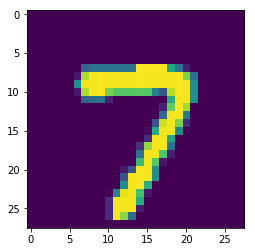

In [24]:
import numpy as np
x_t = np.array(x_ts)
x_t = x_t.reshape(28, 28)
print(x_t.shape)
plt.imshow(x_t)

(28, 28)


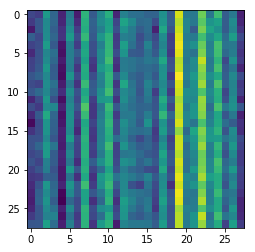

In [25]:
dec_t = np.array(dec_ts)
dec_t = dec_t.reshape(28, 28)
print(dec_t.shape)
plt.imshow(dec_t)

In [10]:
reconst = StochasticReconstructionLoss(encoder_with_recurrence, decoder)
kl = KullbackLeibler(encoder, prior)

step_loss = (reconst + kl).mean()
loss = IterativeLoss(step_loss, max_iter=t_max,
                     series_var=['x'],
                     update_value={"h": "h_prev"})

vrnn = Model(loss, distributions=[encoder, decoder, prior, recurrence],
             optimizer=optim.Adam, optimizer_params={'lr': 1e-3})

print(vrnn)
print_latex(vrnn)

Distributions (for training): 
  q(z|x,h_{prev}), p(x|z,h_{prev}), p(z|h_{prev}), p(h|x,z,h_{prev}) 
Loss function: 
  \sum_{t=1}^{28} mean \left(D_{KL} \left[q(z|x,h_{prev})||p(z|h_{prev}) \right] - \mathbb{E}_{p(h,z|x,h_{prev})} \left[\log p(x|z,h_{prev}) \right] \right) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0
  )


<IPython.core.display.Math object>

In [11]:
def data_loop(epoch, loader, model, device, train_mode=False):
    mean_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(loader)):
        data = data.to(device)
        batch_size = data.size()[0]
        x = data.transpose(0, 1)
        h_prev = torch.zeros(batch_size, recurrence.hidden_size).to(device)
        if train_mode:
            mean_loss += model.train({'x': x, 'h_prev': h_prev}).item() * batch_size
        else:
            mean_loss += model.test({'x': x, 'h_prev': h_prev}).item() * batch_size

    mean_loss /= len(loader.dataset)
    if train_mode:
        print('Epoch: {} Train loss: {:.4f}'.format(epoch, mean_loss))
    else:
        print('Test loss: {:.4f}'.format(mean_loss))
    return mean_loss

In [12]:
def plot_image_from_latent(batch_size):
    x = []
    h_prev = torch.zeros(batch_size, recurrence.hidden_size).to(device)
    for step in range(t_max):
        samples = generate_from_prior.sample({'h_prev': h_prev})
        x_t = decoder.sample_mean({"z": samples["z"], "h_prev": samples["h_prev"]})
        h_prev = samples["h"]
        x.append(x_t[None, :])
    x = torch.cat(x, dim=0).transpose(0, 1)
    return x

In [ ]:
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    train_loss = data_loop(epoch, train_loader, vrnn, device, train_mode=True)
    test_loss = data_loop(epoch, test_loader, vrnn, device)

    writer.add_scalar('train_loss', train_loss, epoch)
    writer.add_scalar('test_loss', test_loss, epoch)

    sample = plot_image_from_latent(batch_size)[:, None]
    writer.add_images('Image_from_latent', sample, epoch)

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 Train loss: 213.7318


  0%|          | 0/1875 [00:00<?, ?it/s]

Test loss: 196.9736


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 Train loss: 189.6261


  0%|          | 0/1875 [00:00<?, ?it/s]

Test loss: 185.0552


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 Train loss: 184.1123


  0%|          | 0/1875 [00:00<?, ?it/s]

Test loss: 180.9454


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 Train loss: 178.7878


100%|██████████| 313/313 [00:34<00:00,  6.68it/s]


Test loss: 176.4252


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 Train loss: 176.8936


  0%|          | 0/1875 [00:00<?, ?it/s]

Test loss: 175.5571


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 6 Train loss: 176.1811


  0%|          | 0/1875 [00:00<?, ?it/s]

Test loss: 175.0856


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 7 Train loss: 175.8236


  0%|          | 0/1875 [00:00<?, ?it/s]

Test loss: 174.6942


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 8 Train loss: 175.5170


  0%|          | 0/1875 [00:00<?, ?it/s]

Test loss: 174.6903


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 9 Train loss: 175.3001


  0%|          | 0/1875 [00:00<?, ?it/s]

Test loss: 174.1828


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 10 Train loss: 175.0960


100%|██████████| 313/313 [00:28<00:00, 10.93it/s]

Test loss: 174.2940
